# 명언 기반 위로 챗봇 구현

> 목표: 서브 그래프를 활용하여 ReAct 구조 RAG 시스템 구현

## 환경 설정

In [2]:
from dotenv import load_dotenv

# 환경변수 로드
load_dotenv()

True

In [3]:
from pprint import pprint

In [4]:
from langfuse.langchain import CallbackHandler

# 콜백 핸들러 생성
langfuse_handler = CallbackHandler()

## 1. 문서 인덱싱

### 1) 데이터 로드

In [5]:
from datasets import load_dataset

# 1) Goodreads 기반 영어 명언 로드
ds1 = load_dataset("Abirate/english_quotes", split="train")

# 2) 동기부여 명언 로드
ds2 = load_dataset("asuender/motivational-quotes", "quotes", split="train")

# 3) 철학자 명언 로드
ds3 = load_dataset("datastax/philosopher-quotes", split="train")

pprint(ds1[0])
pprint(ds2[0])
pprint(ds3[0])


/Users/sunhwaryu/Documents/llm-study/prj03/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'author': 'Oscar Wilde',
 'quote': '“Be yourself; everyone else is already taken.”',
 'tags': ['be-yourself',
          'gilbert-perreira',
          'honesty',
          'inspirational',
          'misattributed-oscar-wilde',
          'quote-investigator']}
{'author': 'Roy T. Bennett',
 'quote': '“Attitude is a choice. Happiness is a choice. Optimism is a choice. '
          'Kindness is a choice. Giving is a choice. Respect is a choice. '
          'Whatever choice you make makes you. Choose wisely.”'}
{'author': 'aristotle',
 'quote': 'True happiness comes from gaining insight and growing into your '
          "best possible self. Otherwise all you're having is immediate "
          "gratification pleasure, which is fleeting and doesn't grow you as a "
          'person.',
 'tags': 'knowledge'}


In [6]:
print(ds1.shape, ds2.shape, ds3.shape)

(2508, 3) (4262, 2) (450, 3)


In [ ]:
from langchain_core.documents import Document
from typing import List, Dict

def to_document(dataset: List[Dict]) -> List[Document]:
    return [
        Document(
            page_content=entry['quote'],
            metadata={
                'author': entry['author'],
                'tags': entry.get('tags', []) or []
            }
        )
        for entry in dataset
    ]

docs1 = to_document(ds1)
docs2 = to_document(ds2)
docs3 = to_document(ds3)

### 2\) 인덱싱

In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import Pinecone 

embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

english_quotes = Pinecone(
    embedding=embeddings_model,
    index_name="english-quotes"
)
motivational_quotes = Pinecone(
    embedding=embeddings_model,
    index_name="motivational-quotes"
)
philosopher_quotes = Pinecone(
    embedding=embeddings_model,
    index_name="philosopher-quotes"
)

BATCH_SIZE = 100
for i in range(0, len(docs1), BATCH_SIZE):
    english_quotes.add_documents(documents=docs1[i:i+BATCH_SIZE])

for i in range(0, len(docs2), BATCH_SIZE):
    motivational_quotes.add_documents(documents=docs2[i:i+BATCH_SIZE])

for i in range(0, len(docs3), BATCH_SIZE):
    philosopher_quotes.add_documents(documents=docs3[i:i+BATCH_SIZE])

## 2. 도구 정의

In [64]:
from langchain_core.tools import tool
from typing import List

@tool
def search_english_quotes(query:str) -> List[Document]:
    """" 
    Search the top 5 relevant quotes from the Goodreads English quotes collection.
    Given a query, returns a list of inspirational quotes matching the query.
    """
    return english_quotes.similarity_search(query, k=5)
    
@tool
def search_motivational_quotes(query:str) -> List[Document]:
    """
    Retrieve the top 5 motivational quotes relevant to the user's query.
    Searches a curated collection of motivational quotes for the best matches.
    """
    return motivational_quotes.similarity_search(query, k=5)
    
@tool
def search_philosopher_quotes(query:str) -> List[Document]:
    """
    Find the top 5 philosophical quotes related to the input query.
    Searches a collection of famous philosopher quotes to provide insightful matches.
    """
    return philosopher_quotes.similarity_search(query, k=5)

In [65]:
from langchain_openai import ChatOpenAI

# 검색 도구 정의
search_tools = [
    search_english_quotes, 
    search_motivational_quotes, 
    search_philosopher_quotes
]

# 검색 도구 바인딩
llm = ChatOpenAI(model="gpt-4.1-mini")
llm_with_tools = llm.bind_tools(tools=search_tools)

## 3. 서브그래프 정의

- 메시지 기록은 필요한 부분만 구현

### 1\) 문서 검색

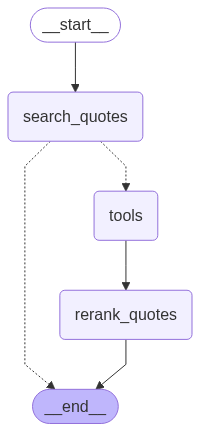

In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage
from langchain.retrievers.document_compressors import LLMListwiseRerank
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Annotated, TypedDict
from IPython.display import Image, display


SEARCH_PROMPT = """
You are a helpful assistant with access to multiple quote search tools.
When a user provides a query, use the appropriate tool to find relevant quotes.
"""

# LLM Reranker 정의
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
re_ranker = LLMListwiseRerank.from_llm(llm, top_n=3)

class SearchState(TypedDict):
    query: str
    documents: List[Document]
    messages: Annotated[list[str], add_messages]

def search_node(state: SearchState):
    messages = [
        SystemMessage(content=SEARCH_PROMPT),
        HumanMessage(content=state["query"])
    ]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def rerank_node(state: SearchState):
    messages = state["messages"][-3:]
    docs = []

    for msg in messages:
        if "ToolMessage" in str(type(msg)):
            docs += eval(msg.content)
        
    reranked_docs = re_ranker.compress_documents(
        docs,
        state["query"]
    )
    return {"documents": reranked_docs}

# 그래프 생성
search_workflow = StateGraph(SearchState)

# 도구 노드 정의
tool_node = ToolNode(
    tools=search_tools,
    name="tools",
    messages_key="messages"
)

# 노드 추가
search_workflow.add_node("search_quotes", search_node)
search_workflow.add_node("tools", tool_node)
search_workflow.add_node("rerank_quotes", rerank_node)

# 노드 연결
search_workflow.add_edge(START, "search_quotes")
search_workflow.add_conditional_edges("search_quotes", tools_condition)
search_workflow.add_edge("tools", "rerank_quotes")
search_workflow.add_edge("rerank_quotes", END)

# 그래프 컴파일
search_graph = search_workflow.compile()
display(Image(search_graph.get_graph().draw_mermaid_png()))

In [140]:
# Test
result = search_graph.invoke({"query": "I'm feeling sad and need motivation and the Goodreads English quotes collection."})

for msg in result.get("messages", []):
    print(msg.pretty_print())

print("---"*10)

for msg in result.get("documents", []):
    pprint(msg)

================================== Ai Message ==================================
Tool Calls:
  search_motivational_quotes (call_u2V013TllvIYnf9LyUirUgE5)
 Call ID: call_u2V013TllvIYnf9LyUirUgE5
  Args:
    query: motivation
  search_english_quotes (call_r1FQ4drTJpotoModPYrzJq1W)
 Call ID: call_r1FQ4drTJpotoModPYrzJq1W
  Args:
    query: motivation
None
================================= Tool Message =================================
Name: search_motivational_quotes

[Document(id='d24d4292-93c2-414a-8b73-2ad304e05331', metadata={'author': 'Zig Ziglar', 'tags': []}, page_content='“Motivation is the fuel, necessary to keep the human engine running.”'), Document(id='106af173-f6c8-4330-81c5-b43b2a4a1c9a', metadata={'author': 'Dr. Anhad Kaur Suri', 'tags': []}, page_content='“Motivation supplies ignition, and habit provides fuel, to the flame of desire”'), Document(id='9d3f0fbe-6514-48ab-90cd-bd1870deaa11', metadata={'author': 'Todd Stocker', 'tags': []}, page_content='“Motivation gets you go

### 2\) 응답 생성

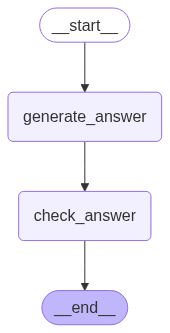

In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, TypedDict
from pydantic import BaseModel, Field
from IPython.display import Image, display


ANSWER_PROMPT = """
You are a compassionate assistant.
Using the following documents and the user query, generate a comforting and relevant response.
Respond in a friendly and encouraging tone.
"""

CHECK_PROMPT = """
Given the user's query and the response, determine if the response genuinely provides comforting or encouraging support relevant to the user's query.

Return the result in JSON with these fields:
- is_comforting: true or false
- comment: brief explanation
"""

# 모델 정의
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

class AnswerState(TypedDict):
    query: str
    documents: List[Document]
    answer: str
    is_comforting: bool
    messages: Annotated[list[str], add_messages]

class ComfortCheckResult(BaseModel):
    is_comforting: bool = Field(..., description="위로나 격려가 되는 응답이면 True, 아니면 False")
    comment: str = Field(..., description="판단에 대한 간단한 설명")

def answer_node(state: AnswerState):
    context = '\n\n'.join(
        [doc.page_content + "\n- " + doc.metadata.get("author", "Unknown")
         for doc in state["documents"]]
    )
    prompt = [
        SystemMessage(content=ANSWER_PROMPT),
        HumanMessage(content=f"User Query:\n{state["query"]}\n\nDocuments:\n{context}"
                              "\n\nPlease write a short, kind, and uplifting message.")
    ]
    response = llm.invoke(prompt)
    return {"messages": [response], "answer": response.content}

def check_node(state: AnswerState):
    prompt = [
        SystemMessage(content=CHECK_PROMPT),
        HumanMessage(content=f"User Query:\n{state["query"]}\n\nResponse:\n{state["answer"]}")
    ]
    response = llm.with_structured_output(ComfortCheckResult).invoke(prompt)
    return {"messages": [AIMessage(content=response.comment)], "is_comforting": response.is_comforting}

def check_condition(state: AnswerState):
    if state.get("is_comforting", False):
        return END
    
    return "generate_answer"


# 그래프 생성
answer_workflow = StateGraph(AnswerState)

# 노드 추가
answer_workflow.add_node("generate_answer", answer_node)
answer_workflow.add_node("check_answer", check_node)

# 노드 연결
answer_workflow.add_edge(START, "generate_answer")
answer_workflow.add_edge("generate_answer", "check_answer")
answer_workflow.add_conditional_edges("check_answer", check_condition)

# 그래프 컴파일
answer_graph = answer_workflow.compile()
display(Image(answer_graph.get_graph().draw_mermaid_png()))

In [146]:
# Test
result2 = answer_graph.invoke(result)

for msg in result2.get("messages", []):
    print(msg.pretty_print())

print("---"*10)

for msg in result2.get("documents", []):
    pprint(msg)

================================== Ai Message ==================================
Tool Calls:
  search_motivational_quotes (call_u2V013TllvIYnf9LyUirUgE5)
 Call ID: call_u2V013TllvIYnf9LyUirUgE5
  Args:
    query: motivation
  search_english_quotes (call_r1FQ4drTJpotoModPYrzJq1W)
 Call ID: call_r1FQ4drTJpotoModPYrzJq1W
  Args:
    query: motivation
None
================================= Tool Message =================================
Name: search_motivational_quotes

[Document(id='d24d4292-93c2-414a-8b73-2ad304e05331', metadata={'author': 'Zig Ziglar', 'tags': []}, page_content='“Motivation is the fuel, necessary to keep the human engine running.”'), Document(id='106af173-f6c8-4330-81c5-b43b2a4a1c9a', metadata={'author': 'Dr. Anhad Kaur Suri', 'tags': []}, page_content='“Motivation supplies ignition, and habit provides fuel, to the flame of desire”'), Document(id='9d3f0fbe-6514-48ab-90cd-bd1870deaa11', metadata={'author': 'Todd Stocker', 'tags': []}, page_content='“Motivation gets you go

## 4. 최종 그래프 정의 및 테스트

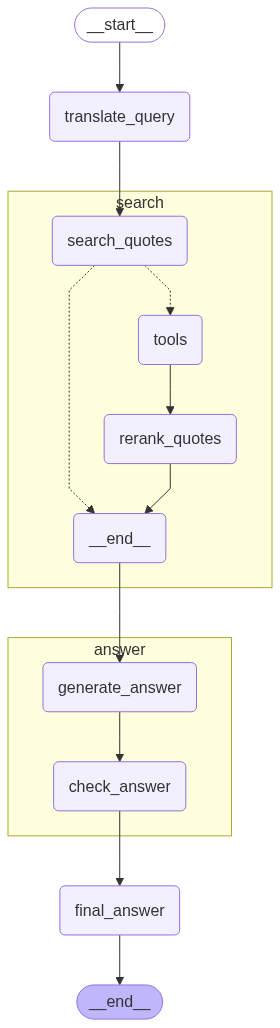

In [191]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver
from typing import Annotated, Optional, TypedDict
from pydantic import BaseModel, Field
from langdetect import detect
from IPython.display import Image, display


TRANSLATE_PROMPT = "Translate the following text into English, regardless of its original language."
FINAL_PROMPT = """
Please translate the English text into the input language.
Respond in a friendly and encouraging tone.
"""

# 모델 정의
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

class GraphState(TypedDict):
    query: str
    original_query:str
    language: str
    documents: List[Document]
    answer: str
    is_comforting: bool
    messages: Annotated[list[str], add_messages]

class TranslationResult(BaseModel):
    translated_query: str = Field(..., description="Input text translated into English")

def translate_node(state: GraphState):
    detected_lang = detect(state["query"]).upper()
    output = {"language": detected_lang, "original_query": state["query"]}

    if "EN" in detected_lang:
        return output

    prompt = [
        SystemMessage(content=TRANSLATE_PROMPT),
        HumanMessage(content=f"Text:\n{state["query"]}")
    ]
    response = llm.with_structured_output(TranslationResult).invoke(prompt)
    output["query"] = response.translated_query
    return output

def final_node(state: GraphState):
    if "EN" in state["language"]:
        return {"answer": state["answer"]}

    prompt = [
        SystemMessage(content=FINAL_PROMPT),
        HumanMessage(content=f"Input Language:\n{state["language"]}\n\nText:\n{state["answer"]}")
    ]
    response = llm.with_structured_output(TranslationResult).invoke(prompt)
    return {"answer": response.translated_query}

def call_search_graph(state: GraphState):
    subgraph_input = {"query": state["query"]}
    subgraph_output = search_graph.invoke(subgraph_input)
    return {**subgraph_output}

def call_answer_graph(state: GraphState):
    subgraph_input = {**state}
    subgraph_output = answer_graph.invoke(subgraph_input)
    return {**subgraph_output}

# 그래프 생성
final_workflow = StateGraph(GraphState)

# 노드 추가
final_workflow.add_node("translate_query", translate_node)
final_workflow.add_node("final_answer", final_node)
# final_workflow.add_node("search", call_search_graph)
# final_workflow.add_node("answer", call_answer_graph)

final_workflow.add_node("search", search_graph)
final_workflow.add_node("answer", answer_graph)

# 노드 연결
final_workflow.add_edge(START, "translate_query")
final_workflow.add_edge("translate_query", "search")
final_workflow.add_edge("search", "answer")
final_workflow.add_edge("answer", "final_answer")
final_workflow.add_edge("final_answer", END)

# 메모리 저장소 생성
checkpointer = InMemorySaver()

# 그래프 컴파일
final_graph = final_workflow.compile(checkpointer=checkpointer)
display(Image(final_graph.get_graph(xray=True).draw_mermaid_png()))

In [192]:
testset = [
    "요즘 너무 힘들어요. 위로가 될 만한 말을 해주세요.",
    "I'm feeling really down lately. Can you share something uplifting with me?",
    "무기력하고 우울합니다. 에너지를 얻을 수 있는 한 마디가 필요해요.",
    "I feel so tired and defeated. I need a little inspiration—can you offer some?",
    "지치고 의욕이 없어요. 다시 힘을 낼 수 있는 응원이 필요해요."
]

In [208]:
for id, query in enumerate(testset):
    test = final_graph.invoke(
        {"query": query},
        {"configurable": {"thread_id": f"{id}"},
         "callbacks": [langfuse_handler]}
    )

    for msg in test.get("messages", []):
        print(msg.pretty_print())

    print("---"*10)

    for msg in test.get("documents", []):
        pprint(msg.page_content + "\n- " + msg.metadata.get("author", "Unknown"))

    print("---"*10)
    pprint(test["answer"])

================================== Ai Message ==================================
Tool Calls:
  search_motivational_quotes (call_HVI3QKW3GwZ48RKhwcHsc9ZA)
 Call ID: call_HVI3QKW3GwZ48RKhwcHsc9ZA
  Args:
    query: comfort in tough times
None
================================= Tool Message =================================
Name: search_motivational_quotes

[Document(id='22b4c107-7053-41b0-aad1-4e4647172351', metadata={'author': 'Lailah Gifty Akita', 'tags': []}, page_content='“Still trust in God, even if the going gets tough.”'), Document(id='e1e80160-c158-4b11-ade3-5edf55638d82', metadata={'author': 'Gift Gugu Mona', 'tags': []}, page_content='“Life will always throw different situations at you, no matter who you are or where you are, but there is comfort in knowing that no situation will last forever. No matter how hard it gets, plan to overcome and there will always be a way out.”'), Document(id='b037e9a0-a132-4acd-a842-a1c650cdf75d', metadata={'author': 'Gift Gugu Mona', 'tags': []}, 

## 5. 체크포인터 확인

In [209]:
# 상태 히스토리 출력
config = {"configurable": {"thread_id": "0"}}
state_history = list(final_graph.get_state_history(config))

for i, state_snapshot in enumerate(state_history):
    print(f"  Checkpoint {i}:")
    print(f"    Values: {state_snapshot.values.keys()}")
    print(f"    Next: {state_snapshot.next}")
    print(f"    Config: {state_snapshot.config}")
    print("-" * 100)

  Checkpoint 0:
    Values: dict_keys(['query', 'original_query', 'language', 'documents', 'answer', 'is_comforting', 'messages'])
    Next: ()
    Config: {'configurable': {'thread_id': '0', 'checkpoint_ns': '', 'checkpoint_id': '1f05ff34-1335-6672-8004-94ac8bcc1bea'}}
----------------------------------------------------------------------------------------------------
  Checkpoint 1:
    Values: dict_keys(['query', 'original_query', 'language', 'documents', 'answer', 'is_comforting', 'messages'])
    Next: ('final_answer',)
    Config: {'configurable': {'thread_id': '0', 'checkpoint_ns': '', 'checkpoint_id': '1f05ff34-00a7-68ac-8003-5a63ba636f5f'}}
----------------------------------------------------------------------------------------------------
  Checkpoint 2:
    Values: dict_keys(['query', 'original_query', 'language', 'documents', 'messages'])
    Next: ('answer',)
    Config: {'configurable': {'thread_id': '0', 'checkpoint_ns': '', 'checkpoint_id': '1f05ff33-ed4a-63fe-8002-7eee

In [204]:
from langgraph.checkpoint.sqlite import SqliteSaver

with SqliteSaver.from_conn_string("checkpoints.db") as sqlite:
    # 메모리 저장소를 지정하여 그래프 컴파일
    graph_memory = final_workflow.compile(checkpointer=sqlite)

    # 현재 상태 출력 (가장 최근 상태)
    config = {"configurable": {"thread_id": "0"}}

    # 초기 메시지 설정
    initial_input = {"query": testset[0]}

    # 그래프 실행
    output = graph_memory.invoke(initial_input, config)

    # 최종 결과 출력
    pprint(output)

{'answer': '지금 힘든 시간을 보내고 있다니 정말 미안해요. 가장 어려운 순간에도 꼭 버티고 자신을 포기하지 마세요. 인내와 '
           '믿음으로 상황은 분명 좋아질 거예요. 더 밝은 날들이 올 거라고 믿으세요—당신은 생각보다 훨씬 강하고 이겨낼 수 '
           '있어요. 자신을 믿고 한 걸음씩 나아가세요. 당신은 혼자가 아니에요.',
 'documents': [Document(id='98f65a7d-6552-4bbe-9a3e-25b6ec272c2c', metadata={'author': 'Gift Gugu Mona', 'tags': []}, page_content='“When going through hard times, hold on tight until you overcome. With perseverance and God on your side, things will get better. Never give up on yourself, no matter how hard life becomes. One day, you will be fine.”'),
               Document(id='22b4c107-7053-41b0-aad1-4e4647172351', metadata={'author': 'Lailah Gifty Akita', 'tags': []}, page_content='“Still trust in God, even if the going gets tough.”'),
               Document(id='cc0e9605-79c7-44db-9018-76cb4195c163', metadata={'author': 'Gift Gugu Mona', 'tags': []}, page_content='“Sometimes life will put you through tough times. Choose not to give up until you overcome.”')],
 'is_comforting': Tr

In [205]:
with SqliteSaver.from_conn_string("checkpoints.db") as sqlite:
    # 메모리 저장소를 지정하여 그래프 컴파일
    graph_memory = final_workflow.compile(checkpointer=sqlite)

    # 현재 상태 출력 (가장 최근 상태)
    config = {"configurable": {"thread_id": "0"}}
    current_state = graph_memory.get_state(config)

    # 현재 상태의 속성 출력
    print(f"config: {current_state.config}")
    print("-" * 100)
    print(f"next: {current_state.next}")
    print("-" * 100)
    print("values:")
    pprint(current_state.values)

config: {'configurable': {'thread_id': '0', 'checkpoint_ns': '', 'checkpoint_id': '1f05ff2a-29a8-6210-8004-e8f322e682e1'}}
----------------------------------------------------------------------------------------------------
next: ()
----------------------------------------------------------------------------------------------------
values:
{'answer': '지금 힘든 시간을 보내고 있다니 정말 미안해요. 가장 어려운 순간에도 꼭 버티고 자신을 포기하지 마세요. 인내와 '
           '믿음으로 상황은 분명 좋아질 거예요. 더 밝은 날들이 올 거라고 믿으세요—당신은 생각보다 훨씬 강하고 이겨낼 수 '
           '있어요. 자신을 믿고 한 걸음씩 나아가세요. 당신은 혼자가 아니에요.',
 'documents': [Document(id='98f65a7d-6552-4bbe-9a3e-25b6ec272c2c', metadata={'author': 'Gift Gugu Mona', 'tags': []}, page_content='“When going through hard times, hold on tight until you overcome. With perseverance and God on your side, things will get better. Never give up on yourself, no matter how hard life becomes. One day, you will be fine.”'),
               Document(id='22b4c107-7053-41b0-aad1-4e4647172351', metadata={'author': 'Lailah Gif